<a href="https://colab.research.google.com/github/kd-kdev/CognitiveRadio-LSTM/blob/main/LSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predviđanje stanja kanala uz pomoć LSTM (Long Short-Term Memory) modela
Uz pomoć PyTorch tehnologije, simuliramo više frekventnih kanala kao i njihovu dostupnost kroz vreme.
Koristimo LSTM model koji treniramo na simulaciji jednog spektra i pravimo predviđanja o budućim stanjima spektra na osnovu njegovih prethodnih stanja.

Rad se sastoji iz sledećih delova:
1. Importujemo neophodne biblioteke
2. Simuliramo spektar kao i njegovo stanje kroz vreme koristeći funkciju `simulate_multiple_channels`
3. Pripremamo/obrađujemo podatke u format pogodan za input na LSTM model
4. Definišemo LSTM model
5. Pripremamo DataLoader, spremamo podatke za treniranje
6. Training loop - treniramo model na simuliranim podacima
7. Nasumično odabiramo deo prethodno simuliranih podataka, i predviđamo buduće stanje kanala uz pomoć LSTM modela
8. Proveravamo preciznost modela
9. Poredimo realno stanja kanala sa predviđenim stanjem

# 1. Importing required libraries

In [ ]:
!pip install torchview
!pip install torchviz
!pip install torch-summary

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import random
from torchview import draw_graph
from torchviz import make_dot
from IPython.display import Image
from torchsummary import summary

# 2. Simulate channel occupancy

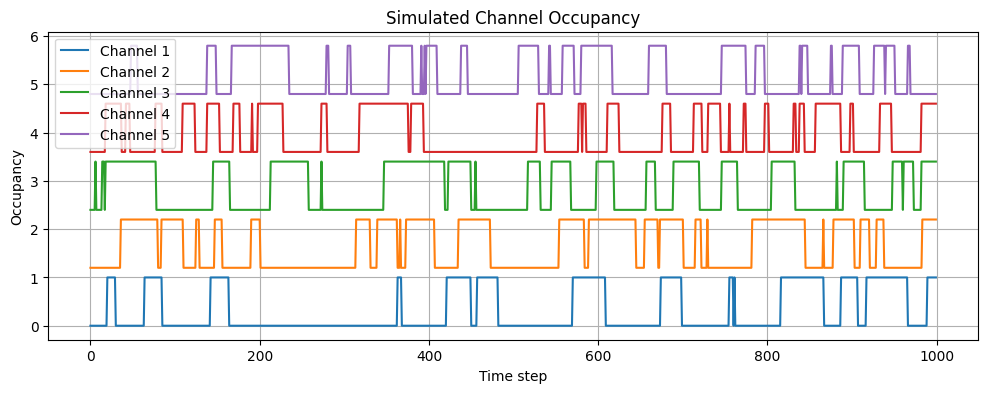

In [ ]:
def simulate_multiple_channels(num_channels=5, length=1000, avg_on_duration=20, avg_off_duration=30):
    channels = []
    for _ in range(num_channels):
        channel = []
        state = 0
        while len(channel) < length:
            duration = np.random.exponential(scale=avg_on_duration if state == 1 else avg_off_duration)
            duration = int(max(1, round(duration)))
            channel.extend([state] * duration)
            state = 1 - state
        channels.append(channel[:length])
    return np.array(channels)

channel_data = simulate_multiple_channels()

# Plot
plt.figure(figsize=(12, 4))
for i in range(channel_data.shape[0]):
    plt.plot(channel_data[i] + i * 1.2, label=f"Channel {i+1}")
plt.title("Simulated Channel Occupancy")
plt.xlabel("Time step")
plt.ylabel("Occupancy")
plt.legend()
plt.grid(True)
plt.show()

# 3. Data preparation

In [ ]:
channel_data = channel_data.T # this transposes it to shape (time_steps, num_channels) for sequence slicing

def create_sequence(channel_data, window_size=100, horizon=10):
  X = [] # sequence of past channel states, contains a fixed length window of past observations
  y = [] # sequence of steps after 10 steps (horizon, the num. of steps in the future we want to predict)
  for i in range(len(channel_data) - window_size - horizon +1):
    X.append(channel_data[i:i+window_size])
    y.append(channel_data[i+window_size : i+window_size+horizon])
  return np.array(X), np.array(y)

X, y = create_sequence(channel_data, window_size=100, horizon=10)
print(f"X.shape = {X.shape}, y.shape = {y.shape}")
# will give you 891 training samples from the dataset, 100 time steps, 5 values per channel

X.shape = (891, 100, 5), y.shape = (891, 10, 5)


# 4. Defining the LSTM model

In [ ]:
class LSTM_model(nn.Module):
  def __init__(self, num_channels, horizon=10, hidden_size=256):
    super().__init__()
    self.horizon = horizon
    self.num_channels = num_channels
    self.lstm = nn.LSTM(input_size=num_channels, hidden_size=hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_channels * horizon)

  def forward(self, x):
    out, _ =self.lstm(x)
    last_out = out[:, -1, :]
    preds = self.fc(last_out)
    preds = preds.view(-1, self.horizon, self.num_channels)
    return torch.sigmoid(preds)

# 5. Prepare dataset for training using DataLoader

In [ ]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)

batch_size = 64 # try out different values like 32 as well
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 6. Training loop

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Training Parameters
num_channels = X.shape[2]  # 5 channels
horizon = y.shape[1]       # 10 time steps ahead
loss_values = []
epochs = 20
lr = 0.001 # learning rate

model = LSTM_model(num_channels=num_channels, horizon=horizon)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()

# Training loop
for epoch in range(1, epochs +1):
  model.train()
  epoch_loss = 0.0

  for X_batch, y_batch in dataloader:
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    optimizer.zero_grad()
    outputs = model(X_batch)
    loss = criterion(outputs, y_batch)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item() * X_batch.size(0)

  avg_loss = epoch_loss / len(dataset)
  loss_values.append(avg_loss)
  print(f"Epoch {epoch}/{epochs} - Loss: {avg_loss:.4f}")

Using device: cuda
Epoch 1/20 - Loss: 0.6796
Epoch 2/20 - Loss: 0.6420
Epoch 3/20 - Loss: 0.6137
Epoch 4/20 - Loss: 0.5715
Epoch 5/20 - Loss: 0.5423
Epoch 6/20 - Loss: 0.5152
Epoch 7/20 - Loss: 0.4845
Epoch 8/20 - Loss: 0.4496
Epoch 9/20 - Loss: 0.4302
Epoch 10/20 - Loss: 0.4230
Epoch 11/20 - Loss: 0.3988
Epoch 12/20 - Loss: 0.3935
Epoch 13/20 - Loss: 0.3490
Epoch 14/20 - Loss: 0.3272
Epoch 15/20 - Loss: 0.3111
Epoch 16/20 - Loss: 0.2997
Epoch 17/20 - Loss: 0.4953
Epoch 18/20 - Loss: 0.4654
Epoch 19/20 - Loss: 0.4057
Epoch 20/20 - Loss: 0.3822


Smallest loss is: 0.2997
Largest loss is: 0.6796
Last loss value is: 0.3822


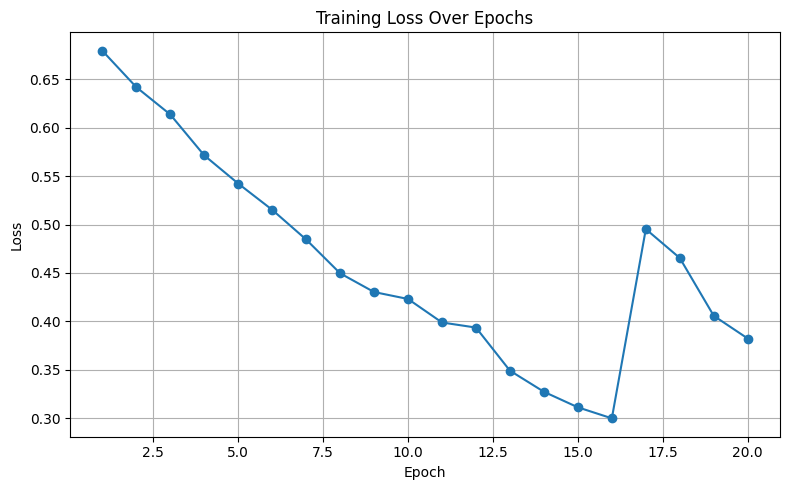

In [ ]:
min_loss_value = min(loss_values)
max_loss_value = max(loss_values)
last_loss_value = loss_values[epochs-1]
print(f"Smallest loss is: {min_loss_value:.4f}")
print(f"Largest loss is: {max_loss_value:.4f}")
print(f"Last loss value is: {last_loss_value:.4f}")
# Loss curve plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), loss_values, marker='o', linestyle='-')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Evaluation on sample

In [ ]:
indices = np.arange(len(X))
#np.random.seed(23)  # For reproducibility, comment out for random
np.random.shuffle(indices)
accuracy_values = []

split_idx = int(len(X) * 0.8)  # 80% train, 20% test

train_indices = indices[:split_idx]
test_indices = indices[split_idx:]

train_X = X[train_indices]
train_y = y[train_indices]

test_X = X[test_indices]
test_y = y[test_indices]

# Suppose test_X, test_y are your test numpy arrays prepared similarly to X, y
test_X_tensor = torch.tensor(test_X, dtype=torch.float32).to(device)
test_y_tensor = torch.tensor(test_y, dtype=torch.float32).to(device)

model.eval()
model.to(device)

with torch.no_grad():
    preds = model(test_X_tensor)  # shape: (num_samples, horizon, num_channels)

preds_binary = (preds >= 0.5).int() # converts probabilities to either 1 or 0


correct = (preds_binary == test_y_tensor.int()).sum().item()
total = torch.numel(test_y_tensor)
accuracy = correct / total
print(f"Test accuracy: {accuracy*100:.2f}%")

accuracy_values.append(accuracy * 100)

# testing
#print(f"preds: {preds}")
#print(f"test X tensor: {test_X_tensor}")
#print(f"correct: {correct}")
#print(f"total: {total}")

Test accuracy: 49.37%
preds: tensor([[[0.4900, 0.5058, 0.4898, 0.4991, 0.4882],
         [0.4965, 0.5086, 0.4833, 0.5117, 0.4841],
         [0.4953, 0.5093, 0.4944, 0.4993, 0.5087],
         ...,
         [0.4839, 0.5142, 0.5102, 0.4900, 0.5091],
         [0.5046, 0.4893, 0.4944, 0.4935, 0.5024],
         [0.5038, 0.5008, 0.4941, 0.5082, 0.4717]],

        [[0.4868, 0.5113, 0.4915, 0.5030, 0.4866],
         [0.5001, 0.5026, 0.4855, 0.4975, 0.4915],
         [0.4942, 0.5076, 0.4907, 0.4970, 0.5088],
         ...,
         [0.4966, 0.5127, 0.5099, 0.4908, 0.5116],
         [0.5026, 0.4849, 0.4890, 0.5015, 0.4996],
         [0.5002, 0.5023, 0.4931, 0.5096, 0.4784]],

        [[0.4897, 0.5079, 0.4896, 0.4982, 0.4907],
         [0.4955, 0.5041, 0.4863, 0.5088, 0.4898],
         [0.4937, 0.5109, 0.4947, 0.4989, 0.5106],
         ...,
         [0.4904, 0.5164, 0.5118, 0.4888, 0.5103],
         [0.5050, 0.4896, 0.4944, 0.4924, 0.4997],
         [0.5015, 0.5042, 0.4955, 0.5031, 0.4757]],

     

Sample data compared with predicted data

In [ ]:
sample_id = random.randint(0, len(test_y_tensor)-1)  # Gets a random sample

# Get tensors for selected sample
actual = test_y_tensor[sample_id].cpu().int().numpy()       # shape: (horizon, num_channels)
predicted = preds_binary[sample_id].cpu().numpy()           # shape: (horizon, num_channels)

# Print comparison per channel
print(f"\nSample Index: {test_indices[sample_id]}")
print(f"X - incorrect prediction")
print(f"O - correct prediction\n")
horizon = actual.shape[0]
num_channels = actual.shape[1]

for ch in range(num_channels):
    actual_str = " ".join(str(actual[t, ch]) for t in range(horizon))
    predicted_str = " ".join(str(predicted[t, ch]) for t in range(horizon))
    correct_str = " ".join("O" if predicted[t, ch] == actual[t, ch] else "X" for t in range(horizon))

    print(f"Channel {ch+1}")
    print(f"Real:      {actual_str}")
    print(f"Predicted: {predicted_str}")
    print(f"Correct:   {correct_str}")
    print()


Sample Index: 698
X - incorrect prediction
O - correct prediction

Channel 1
Real:      0 0 0 0 0 0 0 0 0 0
Predicted: 0 0 0 0 0 0 0 0 0 0
Correct:   O O O O O O O O O O

Channel 2
Real:      1 1 1 1 1 1 1 1 1 1
Predicted: 1 1 1 1 1 1 1 1 1 1
Correct:   O O O O O O O O O O

Channel 3
Real:      0 0 0 0 0 0 0 1 1 1
Predicted: 0 0 0 0 0 0 0 0 0 0
Correct:   O O O O O O O X X X

Channel 4
Real:      1 1 1 1 0 0 0 0 0 0
Predicted: 1 1 1 1 1 1 1 1 1 1
Correct:   O O O O X X X X X X

Channel 5
Real:      0 0 0 0 0 0 0 0 0 0
Predicted: 1 1 1 0 0 0 0 0 0 0
Correct:   X X X O O O O O O O



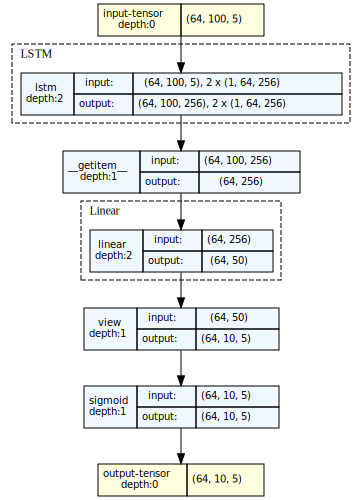

In [ ]:
# torchviz
# Model and input setup
num_channels = 5
horizon = 10
hidden_size = 256
batch_size = 64
seq_length = 100

model = LSTM_model(num_channels=num_channels, horizon=horizon, hidden_size=hidden_size)

# Generate the clean model graph with output shapes
graph = draw_graph(
    model,
    input_size=(batch_size, seq_length, num_channels),  # Input shape: [64, 100, 5]
    device="cpu",
    expand_nested=True,
    depth=3,               # Show internal layers clearly
    save_graph=True,
    graph_name="lstm_training_flow",
    hide_module_functions=False
)

# Display the PNG inline in Colab or Jupyter
graph.visual_graph

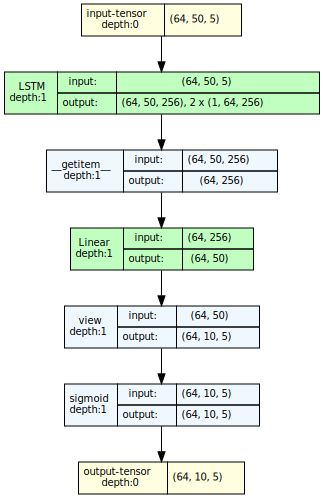

In [ ]:
# test vision graph
batch_size = 64
seq_length = 50          # <-- choose your sequence length
num_channels = 5        # <-- this must match what you used to init your model

model = LSTM_model(num_channels=num_channels)

model_graph = draw_graph(
    model,
    input_size=(batch_size, seq_length, num_channels),  # (B, T, C)
    device='cpu',   # use cpu, not "meta", since LSTM allocates buffers
    expand_nested=True
)

model_graph.visual_graph

In [ ]:
# torchinfo
summary(model)

Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              269,312
├─Linear: 1-2                            12,850
Total params: 282,162
Trainable params: 282,162
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              269,312
├─Linear: 1-2                            12,850
Total params: 282,162
Trainable params: 282,162
Non-trainable params: 0